<a href="https://colab.research.google.com/github/NaviaEddy/SIS421_LAB07/blob/main/Lab06Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importamos las librerias
import torch
import torchvision
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import random

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

# Ruta al archivo zip que deseas descomprimir
zip_file_path = '/content/drive/MyDrive/DatasetPerros_B_S.zip'

# Directorio de destino donde se extraerán los archivos
extract_dir = '/content/extraido.zip'

# Crear el directorio de destino si no existe
os.makedirs(extract_dir, exist_ok=True)

# Descomprimir el archivo zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("¡Descompresión completada!")

¡Descompresión completada!


In [ ]:
import numpy as np
from PIL import Image
import os

def cargar_imagenes_y_mascaras(ruta_imagenes, ruta_mascaras):
    imagenes = []
    mascaras = []

    clases = os.listdir(ruta_imagenes)  # Obtener la lista de clases desde la carpeta de imágenes

    for clase in clases:
        # Ruta a la carpeta de imágenes y máscaras de la clase actual
        ruta_imagenes_clase = os.path.join(ruta_imagenes, clase)
        ruta_mascaras_clase = os.path.join(ruta_mascaras, clase)

        # Obtener la lista de imágenes en la carpeta de imágenes
        imagenes_clase = os.listdir(ruta_imagenes_clase)

        # Iterar sobre las imágenes en la carpeta de imágenes
        for imagen_nombre in imagenes_clase:
            imagen_ruta = os.path.join(ruta_imagenes_clase, imagen_nombre)
            imagen = Image.open(imagen_ruta).convert('RGB')  # Convertir la imagen a RGB
            imagen = np.array(imagen, dtype=np.float32) / 255.0  # Normalizar la imagen y convertirla a float32
            imagenes.append(imagen)

            # Construir la ruta de la máscara correspondiente a la imagen actual
            mascara_nombre = imagen_nombre.split('.')[0] + '.png'  # Cambiar la extensión a .png
            mascara_ruta = os.path.join(ruta_mascaras_clase, mascara_nombre)
            # Verificar si la máscara existe
            if os.path.exists(mascara_ruta):
                # Si existe, cargar la máscara
                mascara = Image.open(mascara_ruta)
                # Aplicar one-hot encoding a las máscaras y agregar un canal para cada clase
                mask_oh = (np.arange(len(clases) + 1) == np.array(mascara)[:, :, 0][..., None]).astype(np.float32)
                mascaras.append(mask_oh)
            else:
                # Si no existe, imprimir un mensaje de advertencia y continuar con la siguiente imagen
                print(f"No se encontró la máscara para la imagen: {imagen_nombre}")

    return imagenes, mascaras


# Rutas a las carpetas de imágenes y máscaras
ruta_mascaras = '/content/extraido.zip/DatasetPerros_B_S/Mask'
ruta_imagenes = '/content/extraido.zip/DatasetPerros_B_S/Perros_dataset'

# Cargar imágenes y máscaras
imagenes, mascaras = cargar_imagenes_y_mascaras(ruta_imagenes, ruta_mascaras)

# Imprimir las propiedades de una imagen y una máscara
img = imagenes[0]
mask = mascaras[0]

print("Propiedades de la imagen:")
print(img.shape, img.dtype, img.max(), img.min())

print("\nPropiedades de la máscara después de one-hot encoding:")
print(mask.shape, mask.dtype, mask.max(), mask.min())

Propiedades de la imagen:
(50, 50, 3) float32 1.0 0.0

Propiedades de la máscara después de one-hot encoding:
(50, 50, 9) float32 1.0 0.0


In [ ]:
len(mascaras)

8000

In [ ]:
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)

    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=9, in_ch=3):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [ ]:
model = UNet()
output = model(torch.randn((10,3,50,50)))
output.shape

torch.Size([10, 9, 50, 50])

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, X, y, epochs=1, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f}")

In [ ]:
# Convertir la imagen a tipo float32
img_tensor = torch.tensor(img).permute(2, 0, 1).unsqueeze(0)
# Mantener las máscaras como uint8
mask_tensor = torch.tensor(mask).permute(2, 0, 1).unsqueeze(0)

img_tensor.shape, mask_tensor.shape

(torch.Size([1, 3, 50, 50]), torch.Size([1, 9, 50, 50]))

In [ ]:
fit(model, img_tensor, mask_tensor, epochs=30)

Epoch 1/30 loss 0.66779
Epoch 2/30 loss 0.65488
Epoch 3/30 loss 0.64352
Epoch 4/30 loss 0.63302
Epoch 5/30 loss 0.62297
Epoch 6/30 loss 0.61328
Epoch 7/30 loss 0.60398
Epoch 8/30 loss 0.59494
Epoch 9/30 loss 0.58606
Epoch 10/30 loss 0.57732
Epoch 11/30 loss 0.56869
Epoch 12/30 loss 0.56019
Epoch 13/30 loss 0.55179
Epoch 14/30 loss 0.54348
Epoch 15/30 loss 0.53528
Epoch 16/30 loss 0.52720
Epoch 17/30 loss 0.51923
Epoch 18/30 loss 0.51137
Epoch 19/30 loss 0.50363
Epoch 20/30 loss 0.49600
Epoch 21/30 loss 0.48848
Epoch 22/30 loss 0.48104
Epoch 23/30 loss 0.47371
Epoch 24/30 loss 0.46646
Epoch 25/30 loss 0.45931
Epoch 26/30 loss 0.45223
Epoch 27/30 loss 0.44526
Epoch 28/30 loss 0.43838
Epoch 29/30 loss 0.43160
Epoch 30/30 loss 0.42490


In [ ]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))
        union = (_out | _labs).float().sum((1, 2))
        iou = (intersection + SMOOTH) / (union + SMOOTH)
        ious.append(iou.mean().item())
    return np.mean(ious)

In [ ]:
def fit(model, X, y, epochs=1, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.5f}")

In [ ]:
fit(model, img_tensor, mask_tensor, epochs=50)

Epoch 1/50 loss 0.41829 iou 0.36836
Epoch 2/50 loss 0.40309 iou 0.49180
Epoch 3/50 loss 0.38114 iou 0.61802
Epoch 4/50 loss 0.36029 iou 0.61790
Epoch 5/50 loss 0.33839 iou 0.61744
Epoch 6/50 loss 0.31912 iou 0.74255
Epoch 7/50 loss 0.30073 iou 0.86780
Epoch 8/50 loss 0.28353 iou 0.86791
Epoch 9/50 loss 0.26698 iou 0.86801
Epoch 10/50 loss 0.25160 iou 0.86801
Epoch 11/50 loss 0.23728 iou 0.86791
Epoch 12/50 loss 0.22381 iou 0.86796
Epoch 13/50 loss 0.21109 iou 0.86796
Epoch 14/50 loss 0.19914 iou 0.86822
Epoch 15/50 loss 0.18800 iou 0.86853
Epoch 16/50 loss 0.17753 iou 0.99395
Epoch 17/50 loss 0.16776 iou 0.99426
Epoch 18/50 loss 0.15862 iou 0.99437
Epoch 19/50 loss 0.15010 iou 0.99463
Epoch 20/50 loss 0.14213 iou 0.99506
Epoch 21/50 loss 0.13467 iou 0.99506
Epoch 22/50 loss 0.12770 iou 0.99527
Epoch 23/50 loss 0.12119 iou 0.99570
Epoch 24/50 loss 0.11510 iou 0.99597
Epoch 25/50 loss 0.10939 iou 0.99613
Epoch 26/50 loss 0.10407 iou 0.99657
Epoch 27/50 loss 0.09911 iou 0.99673
Epoch 28/5

<ipython-input-30-a9fb68643661>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


TypeError: Invalid shape (3, 50, 50) for image data

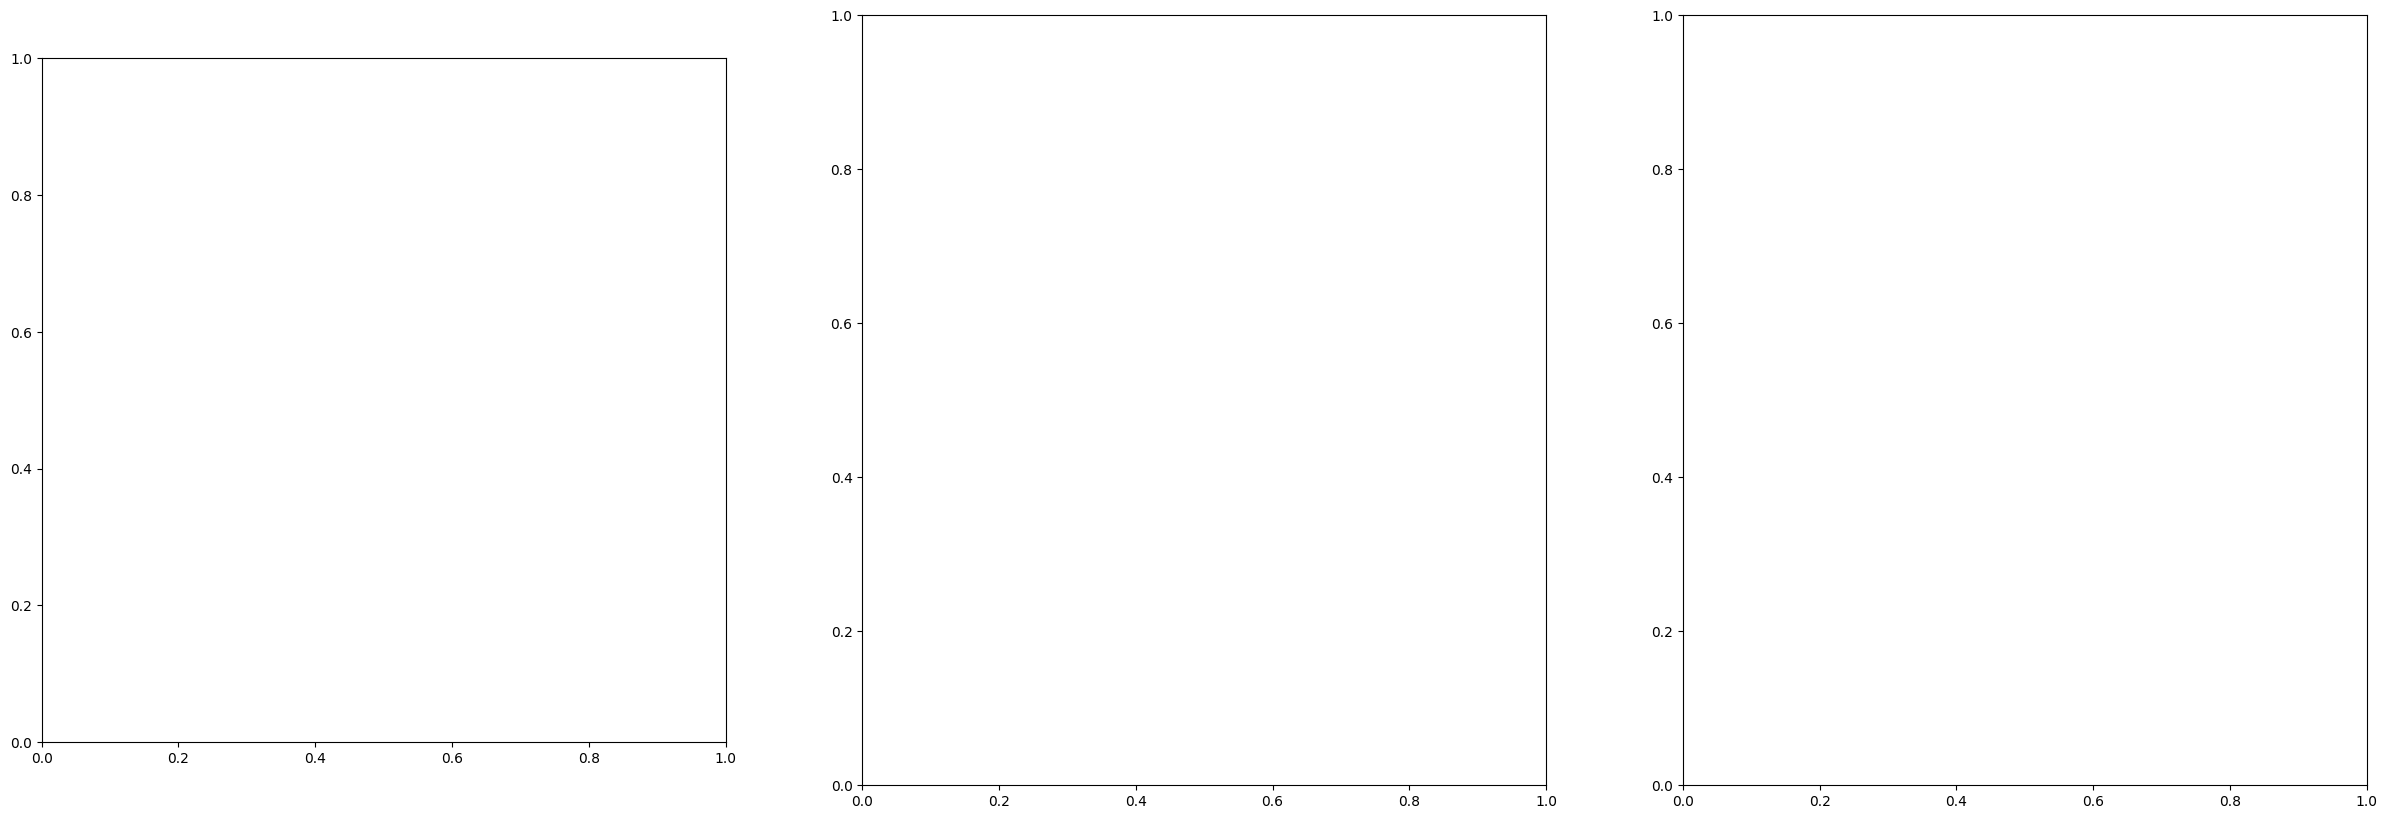

In [67]:
model.eval()
with torch.no_grad():
    output = model(img_tensor.to(device))[0]
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img)
binary_mask = np.argmax(mask*(-1), axis=-1)  # Selección de la clase con el valor más alto en cada píxel
binary_mask = binary_mask.astype(np.uint8)
ax2.imshow(binary_mask)
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

In [ ]:
import os
import numpy as np
from PIL import Image

# Directorio que contiene las subcarpetas con las imágenes en formato PNG
dir_principal = '/content/extraido.zip/DatasetPerros_B_S/Mask'

# Directorio donde se guardarán los arreglos numpy
dir_destino = 'PerrosDataset2/mask'

# Crear el directorio de destino si no existe
os.makedirs(dir_destino, exist_ok=True)

# Contador de archivos convertidos
total_archivos = 0

# Obtener la lista de subcarpetas en el directorio principal
subcarpetas = [subcarpeta for subcarpeta in os.listdir(dir_principal) if os.path.isdir(os.path.join(dir_principal, subcarpeta))]

# Iterar sobre las subcarpetas
for subcarpeta in subcarpetas:
    # Directorio que contiene las imágenes PNG de la subcarpeta actual
    dir_imgs = os.path.join(dir_principal, subcarpeta)

    # Obtener la lista de archivos PNG en la subcarpeta actual
    archivos_png = [archivo for archivo in os.listdir(dir_imgs) if archivo.endswith('.png')]

    # Iterar sobre los archivos PNG
    for archivo_png in archivos_png:
        # Ruta completa del archivo PNG
        ruta_png = os.path.join(dir_imgs, archivo_png)

        # Leer la imagen PNG
        imagen = Image.open(ruta_png)

        # Convertir la imagen a un arreglo numpy
        arreglo_numpy = np.array(imagen)

        # Ruta de destino para guardar el arreglo numpy
        ruta_destino = os.path.join(dir_destino, archivo_png.split('.')[0] + '.npy')

        # Guardar el arreglo numpy en el directorio de destino
        np.save(ruta_destino, arreglo_numpy)

        # Incrementar el contador de archivos
        total_archivos += 1

# Mostrar el número total de archivos convertidos
print(f"Se han convertido y guardado {total_archivos} archivos en la carpeta de destino.")


Se han convertido y guardado 8000 archivos en la carpeta de destino.


In [ ]:
import os
import numpy as np
from PIL import Image

# Directorio que contiene las subcarpetas con las imágenes en formato PNG
dir_principal = '/content/extraido.zip/DatasetPerros_B_S/Perros_dataset'

# Directorio donde se guardarán los arreglos numpy
dir_destino = 'PerrosDataset2/Perros'

# Crear el directorio de destino si no existe
os.makedirs(dir_destino, exist_ok=True)

# Contador de archivos convertidos
total_archivos = 0

# Obtener la lista de subcarpetas en el directorio principal
subcarpetas = [subcarpeta for subcarpeta in os.listdir(dir_principal) if os.path.isdir(os.path.join(dir_principal, subcarpeta))]

# Iterar sobre las subcarpetas
for subcarpeta in subcarpetas:
    # Directorio que contiene las imágenes PNG de la subcarpeta actual
    dir_imgs = os.path.join(dir_principal, subcarpeta)

    # Obtener la lista de archivos PNG en la subcarpeta actual
    archivos_png = [archivo for archivo in os.listdir(dir_imgs) if archivo.endswith('.jpg')]

    # Iterar sobre los archivos PNG
    for archivo_png in archivos_png:
        # Ruta completa del archivo PNG
        ruta_png = os.path.join(dir_imgs, archivo_png)

        # Leer la imagen PNG
        imagen = Image.open(ruta_png)

        # Convertir la imagen a un arreglo numpy
        arreglo_numpy = np.array(imagen)

        # Ruta de destino para guardar el arreglo numpy
        ruta_destino = os.path.join(dir_destino, archivo_png.split('.')[0] + '.npy')

        # Guardar el arreglo numpy en el directorio de destino
        np.save(ruta_destino, arreglo_numpy)

        # Incrementar el contador de archivos
        total_archivos += 1

# Mostrar el número total de archivos convertidos
print(f"Se han convertido y guardado {total_archivos} archivos en la carpeta de destino.")

Se han convertido y guardado 8000 archivos en la carpeta de destino.


In [ ]:
import os
from pathlib import Path

from pathlib import Path
import os

# Directorio principal que contiene las subcarpetas con las imágenes y máscaras
path = Path('./PerrosDataset2')

# Obtener la lista de rutas de imágenes
imgs = [path/'Perros'/i for i in os.listdir(path/'Perros')]

# Obtener la lista de rutas de máscaras
masks = [path/'mask'/i for i in os.listdir(path/'mask')]

len(imgs), len(masks), type(imgs), type(masks)

(8000, 8000, list, list)

In [ ]:
img = np.load(imgs[0])
mask = np.load(masks[0])

img.shape, mask.shape

((50, 50, 3), (50, 50, 3))

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, n_classes=9):
        self.X = X
        self.y = y
        self.n_classes = n_classes

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        img = np.load(self.X[ix])
        mask = np.load(self.y[ix])
        img = torch.tensor(img).permute(2,0,1)

        # Crear una máscara one-hot para cada clase
        mask_one_hot = np.zeros((self.n_classes, *mask.shape[:2]), dtype=np.float32)
        for i in range(self.n_classes):
            mask_one_hot[i][mask[..., 0] == i] = 1

        # Permutar las dimensiones de la máscara para que sea (C, H, W)
        mask_one_hot = torch.from_numpy(mask_one_hot)
        mask_one_hot = mask_one_hot.permute(0,1,2)

        return img.float(), mask_one_hot

In [ ]:
# Tamaño del conjunto de prueba
test_size = 2000

# Dividir el conjunto de datos original en conjuntos de entrenamiento y prueba
imagenes_train = imgs[:-test_size]
masks_train = masks[:-test_size]
imagenes_test = imgs[-test_size:]
masks_test = masks[-test_size:]

# Crear el diccionario de datasets
dataset = {
    'train': Dataset(imagenes_train, masks_train),
    'test': Dataset(imagenes_test, masks_test)
}

# Verificar la longitud de los conjuntos de entrenamiento y prueba
len(dataset['train']), len(dataset['test'])

(6000, 2000)

In [ ]:
import torch
from torch.utils.data import DataLoader

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=32, pin_memory=True)
}

# Obtén un lote de datos de entrenamiento
imgs, masks = next(iter(dataloader['train']))

# Asegúrate de que las dimensiones sean las correctas
imgs.shape, masks.shape

(torch.Size([16, 3, 50, 50]), torch.Size([16, 9, 50, 50]))

In [ ]:
from tqdm import tqdm

def fit(model, dataloader, epochs=100, device=device,lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [ ]:
model = UNet()
hist = fit(model, dataloader, epochs=15)

test_loss 0.05444 test_iou 0.97590: 100%|██████████| 63/63 [00:15<00:00,  4.19it/s]



Epoch 1/15 loss 0.18159 iou 0.84860 test_loss 0.05444 test_iou 0.97590


test_loss 0.03538 test_iou 0.97984: 100%|██████████| 63/63 [00:14<00:00,  4.29it/s]



Epoch 2/15 loss 0.04280 iou 0.97796 test_loss 0.03538 test_iou 0.97984


test_loss 0.03057 test_iou 0.98069: 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]



Epoch 3/15 loss 0.03310 iou 0.97963 test_loss 0.03057 test_iou 0.98069


test_loss 0.02837 test_iou 0.98142: 100%|██████████| 63/63 [00:15<00:00,  4.18it/s]



Epoch 4/15 loss 0.02923 iou 0.98085 test_loss 0.02837 test_iou 0.98142


test_loss 0.02750 test_iou 0.98151: 100%|██████████| 63/63 [00:15<00:00,  4.19it/s]



Epoch 5/15 loss 0.02705 iou 0.98173 test_loss 0.02750 test_iou 0.98151


test_loss 0.02774 test_iou 0.98175: 100%|██████████| 63/63 [00:14<00:00,  4.22it/s]



Epoch 6/15 loss 0.02533 iou 0.98248 test_loss 0.02774 test_iou 0.98175


test_loss 0.02748 test_iou 0.98199: 100%|██████████| 63/63 [00:14<00:00,  4.21it/s]



Epoch 7/15 loss 0.02369 iou 0.98337 test_loss 0.02748 test_iou 0.98199


test_loss 0.02601 test_iou 0.98251: 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]



Epoch 8/15 loss 0.02264 iou 0.98387 test_loss 0.02601 test_iou 0.98251


test_loss 0.02532 test_iou 0.98233: 100%|██████████| 63/63 [00:14<00:00,  4.25it/s]



Epoch 9/15 loss 0.02143 iou 0.98455 test_loss 0.02532 test_iou 0.98233


test_loss 0.02803 test_iou 0.98010: 100%|██████████| 63/63 [00:15<00:00,  4.10it/s]



Epoch 10/15 loss 0.02025 iou 0.98529 test_loss 0.02803 test_iou 0.98010


test_loss 0.02707 test_iou 0.98244: 100%|██████████| 63/63 [00:15<00:00,  4.18it/s]



Epoch 11/15 loss 0.01920 iou 0.98585 test_loss 0.02707 test_iou 0.98244


test_loss 0.02739 test_iou 0.98221: 100%|██████████| 63/63 [00:14<00:00,  4.21it/s]



Epoch 12/15 loss 0.01819 iou 0.98655 test_loss 0.02739 test_iou 0.98221


loss 0.01725 iou 0.98721:  74%|███████▎  | 276/375 [01:32<00:28,  3.46it/s]

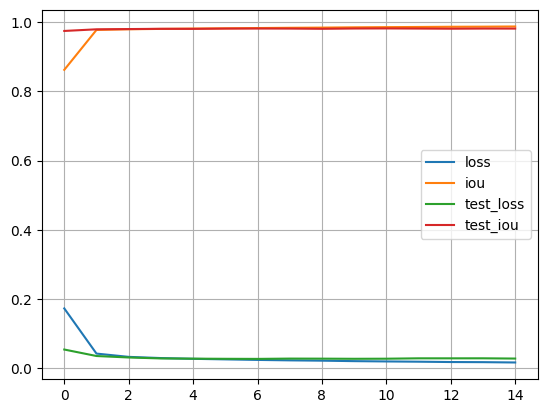

In [ ]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

In [ ]:
import torchvision

In [ ]:
encoder = torchvision.models.resnet18(pretrained=True)
encoder

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 151MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=9, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True)
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = torch.tensor(x.clone())
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

In [ ]:
model = UNetResnet()
output = model(torch.randn((10,3,394,394)))
output.shape

<ipython-input-30-a9fb68643661>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


torch.Size([10, 9, 394, 394])

In [ ]:
model = UNetResnet()
hist = fit(model, dataloader, epochs=15)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/375 [00:00<?, ?it/s]<ipython-input-30-a9fb68643661>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())
test_loss 0.07655 test_iou 0.98273: 100%|██████████| 63/63 [00:02<00:00, 


Epoch 1/15 loss 0.23934 iou 0.89699 test_loss 0.07655 test_iou 0.98273


test_loss 0.03773 test_iou 0.98446: 100%|██████████| 63/63 [00:02<00:00, 27.55it/s]



Epoch 2/15 loss 0.05091 iou 0.98385 test_loss 0.03773 test_iou 0.98446


test_loss 0.02837 test_iou 0.98453: 100%|██████████| 63/63 [00:02<00:00, 30.02it/s]



Epoch 3/15 loss 0.02938 iou 0.98580 test_loss 0.02837 test_iou 0.98453


test_loss 0.02479 test_iou 0.98476: 100%|██████████| 63/63 [00:02<00:00, 30.04it/s]



Epoch 4/15 loss 0.02266 iou 0.98689 test_loss 0.02479 test_iou 0.98476


test_loss 0.02388 test_iou 0.98504: 100%|██████████| 63/63 [00:02<00:00, 26.93it/s]



Epoch 5/15 loss 0.01914 iou 0.98789 test_loss 0.02388 test_iou 0.98504


test_loss 0.02256 test_iou 0.98526: 100%|██████████| 63/63 [00:02<00:00, 28.88it/s]



Epoch 6/15 loss 0.01686 iou 0.98868 test_loss 0.02256 test_iou 0.98526


test_loss 0.02229 test_iou 0.98527: 100%|██████████| 63/63 [00:02<00:00, 25.18it/s]



Epoch 7/15 loss 0.01521 iou 0.98938 test_loss 0.02229 test_iou 0.98527


test_loss 0.02409 test_iou 0.98491: 100%|██████████| 63/63 [00:02<00:00, 29.86it/s]



Epoch 8/15 loss 0.01418 iou 0.98988 test_loss 0.02409 test_iou 0.98491


test_loss 0.02245 test_iou 0.98530: 100%|██████████| 63/63 [00:02<00:00, 28.48it/s]



Epoch 9/15 loss 0.01364 iou 0.99004 test_loss 0.02245 test_iou 0.98530


test_loss 0.02370 test_iou 0.98541: 100%|██████████| 63/63 [00:02<00:00, 29.69it/s]



Epoch 10/15 loss 0.01269 iou 0.99061 test_loss 0.02370 test_iou 0.98541


test_loss 0.02614 test_iou 0.98417: 100%|██████████| 63/63 [00:02<00:00, 29.62it/s]



Epoch 11/15 loss 0.01219 iou 0.99091 test_loss 0.02614 test_iou 0.98417


test_loss 0.02417 test_iou 0.98468: 100%|██████████| 63/63 [00:02<00:00, 26.64it/s]



Epoch 12/15 loss 0.01214 iou 0.99084 test_loss 0.02417 test_iou 0.98468


test_loss 0.02410 test_iou 0.98549: 100%|██████████| 63/63 [00:02<00:00, 29.69it/s]



Epoch 13/15 loss 0.01175 iou 0.99111 test_loss 0.02410 test_iou 0.98549


test_loss 0.02452 test_iou 0.98550: 100%|██████████| 63/63 [00:02<00:00, 24.26it/s]



Epoch 14/15 loss 0.01070 iou 0.99182 test_loss 0.02452 test_iou 0.98550


test_loss 0.02474 test_iou 0.98552: 100%|██████████| 63/63 [00:02<00:00, 29.85it/s]


Epoch 15/15 loss 0.01019 iou 0.99218 test_loss 0.02474 test_iou 0.98552


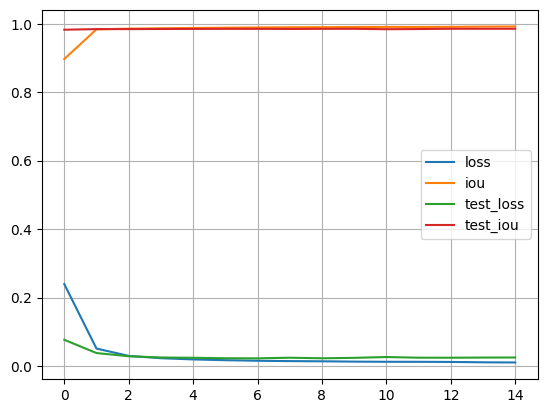

In [ ]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

<ipython-input-30-a9fb68643661>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


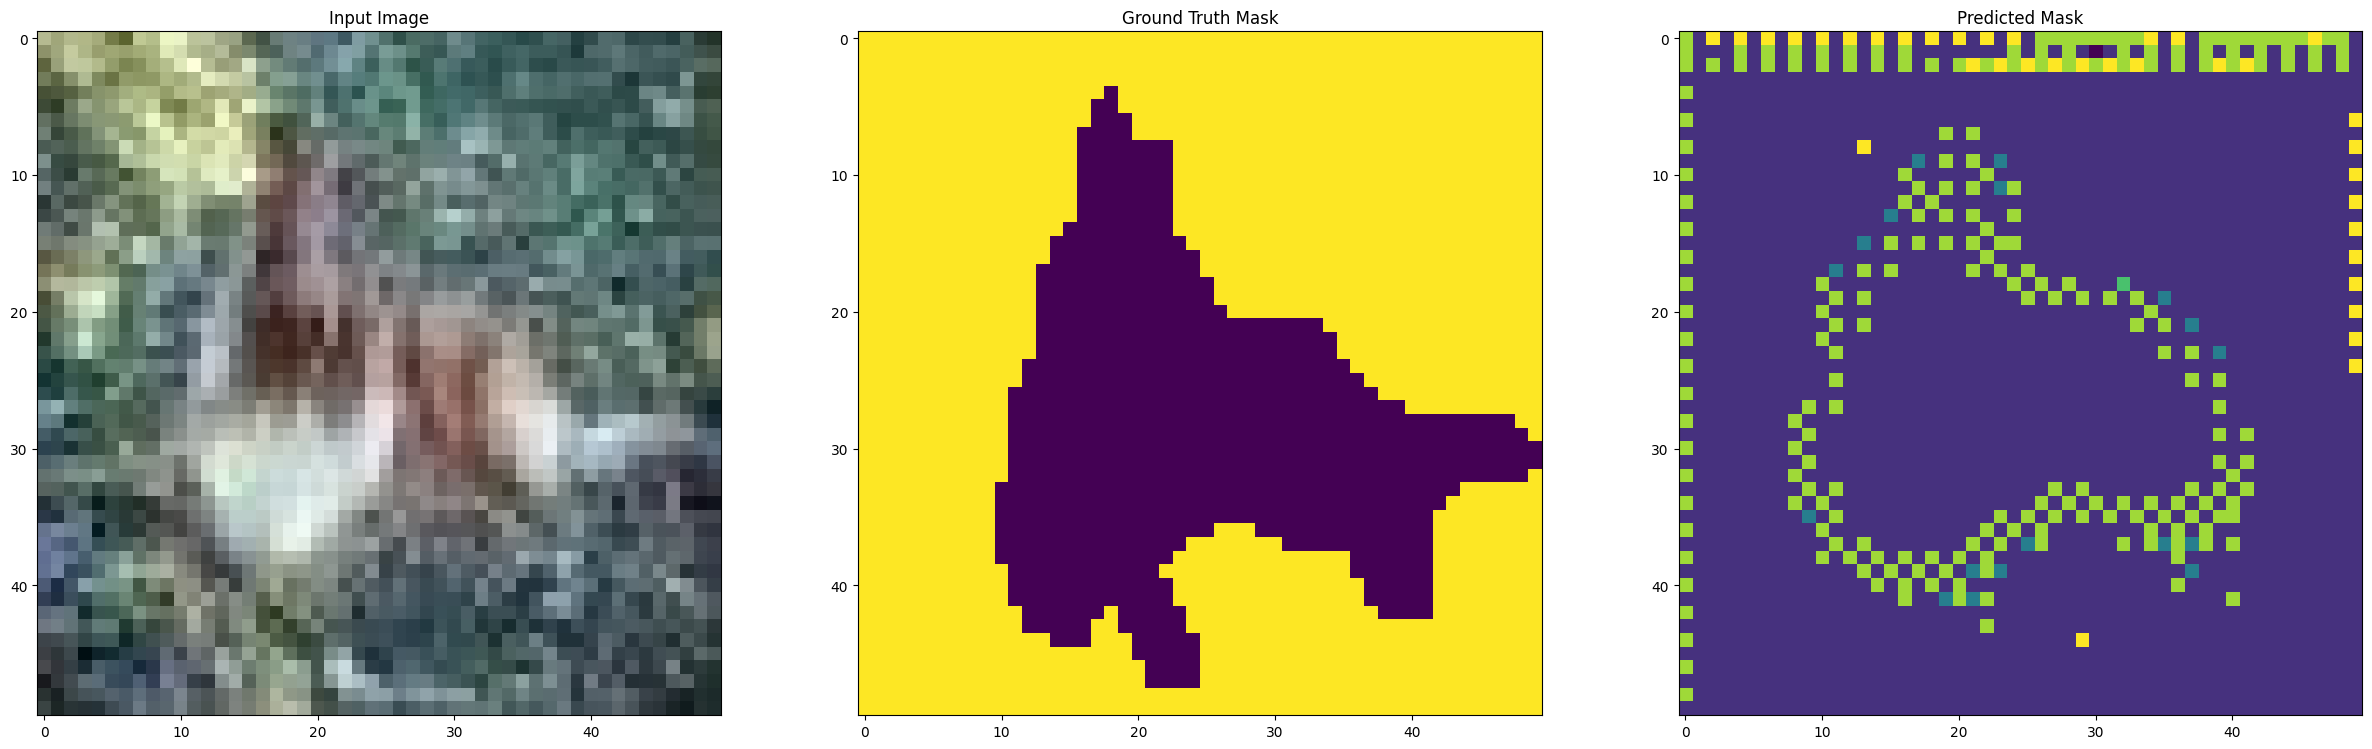

In [66]:
import random
import matplotlib.pyplot as plt

# Suponiendo que 'model', 'dataset' y 'device' ya están definidos

model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dataset['test'])-1)
    img, mask = dataset['test'][ix]
    output = model(img.unsqueeze(0).to(device))[0]
    output = output*(-1)
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img.squeeze(0).permute(1,2,0)/255.)
ax1.set_title('Input Image')
ax2.imshow(torch.argmax(mask*(-1), axis=0))
ax2.set_title('Ground Truth Mask')
ax3.imshow(pred_mask.squeeze().cpu().numpy())
ax3.set_title('Predicted Mask')
plt.show()
